### All data but clean

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

In [2]:
df = pd.read_csv('data/raw_dataset.csv')
df.shape

(4424, 35)

In [3]:
df = df[df["Target"].isin(["Dropout", "Graduate"])].copy()
print("Shape after keeping Dropout/Graduate:", df.shape)

Shape after keeping Dropout/Graduate: (3630, 35)


### Remove Nal first year

In [4]:
first_year_cols = [
    "Curricular units 1st sem (credited)",
    "Curricular units 1st sem (enrolled)",
    "Curricular units 1st sem (evaluations)",
    "Curricular units 1st sem (approved)",
    "Curricular units 1st sem (grade)",
    "Curricular units 1st sem (without evaluations)",
    "Curricular units 2nd sem (credited)",
    "Curricular units 2nd sem (enrolled)",
    "Curricular units 2nd sem (evaluations)",
    "Curricular units 2nd sem (approved)",
    "Curricular units 2nd sem (grade)",
    "Curricular units 2nd sem (without evaluations)"
]
df[first_year_cols] = df[first_year_cols].apply(pd.to_numeric, errors="coerce")
mask_all_zero = (df[first_year_cols] == 0).all(axis=1)

df = df[~mask_all_zero].copy()

print("Shape after removing NAL observations:", df.shape)
print("Removed rows:", mask_all_zero.sum())

Shape after removing NAL observations: (3478, 35)
Removed rows: 152


In [5]:
top_5_features = [
    'Tuition fees up to date',
    'Age at enrollment',
    'Course',
    'Scholarship holder',
    'Application mode',
    'Target'
]
cols_to_drop = [c for c in df.columns if c not in top_5_features]
print(f"Dropping academic history columns: {cols_to_drop}")
print(len(cols_to_drop))

Dropping academic history columns: ['Marital status', 'Application order', 'Daytime/evening attendance', 'Previous qualification', 'Nacionality', "Mother's qualification", "Father's qualification", "Mother's occupation", "Father's occupation", 'Displaced', 'Educational special needs', 'Debtor', 'Gender', 'International', 'Curricular units 1st sem (credited)', 'Curricular units 1st sem (enrolled)', 'Curricular units 1st sem (evaluations)', 'Curricular units 1st sem (approved)', 'Curricular units 1st sem (grade)', 'Curricular units 1st sem (without evaluations)', 'Curricular units 2nd sem (credited)', 'Curricular units 2nd sem (enrolled)', 'Curricular units 2nd sem (evaluations)', 'Curricular units 2nd sem (approved)', 'Curricular units 2nd sem (grade)', 'Curricular units 2nd sem (without evaluations)', 'Unemployment rate', 'Inflation rate', 'GDP']
29


In [6]:
df = df.drop(columns=cols_to_drop).copy()

### Now we have cleand data

In [7]:
print("Cleaned data shape:", df.shape)
print("Target distribution:\n", df["Target"].value_counts())


Cleaned data shape: (3478, 6)
Target distribution:
 Target
Graduate    2134
Dropout     1344
Name: count, dtype: int64


In [8]:
all_feature_cols = [c for c in df.columns if c != "Target"]
categorical_cols = all_feature_cols

In [9]:
for col in categorical_cols:
    df[col] = df[col].astype("category")


In [10]:
df["y"] = (df["Target"] == "Dropout").astype(int)

X = df[all_feature_cols]
y = df["y"]


In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [12]:
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
    ]
)

In [13]:
log_reg = LogisticRegression(
    max_iter=2000,
    # class_weight="balanced"  # uncomment if dropout is very imbalanced
)

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=4,
    random_state=42,
    n_jobs=-1
)

xgb = XGBClassifier(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1
)

pipe_log = Pipeline([("prep", preprocess), ("model", log_reg)])
pipe_rf  = Pipeline([("prep", preprocess), ("model", rf)])
pipe_xgb = Pipeline([("prep", preprocess), ("model", xgb)])

In [14]:
pipe_log.fit(X_train, y_train)
pipe_rf.fit(X_train, y_train)
pipe_xgb.fit(X_train, y_train)

,steps,"[('prep', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [18]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

# 1) פיצול ה-TRAIN ל-TRAIN/VAL (כדי לבחור threshold בלי לגעת ב-test)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42, stratify=y_train
)

# 2) מאמנים על X_tr בלבד
pipe_log.fit(X_tr, y_tr)

# 3) הסתברויות ל-Dropout (y=1) על ה-VAL
proba_val = pipe_log.predict_proba(X_val)[:, 1]

# 4) מחפשים threshold שמביא Recall >= 0.65 וממקסם Precision
target_recall = 0.65
thresholds = np.linspace(0.01, 0.99, 99)

best_t, best_prec, best_rec, best_f1 = None, -1, None, None

for t in thresholds:
    pred_val = (proba_val >= t).astype(int)
    rec = recall_score(y_val, pred_val)
    if rec >= target_recall:
        prec = precision_score(y_val, pred_val, zero_division=0)
        f1 = f1_score(y_val, pred_val, zero_division=0)
        if prec > best_prec:
            best_t, best_prec, best_rec, best_f1 = t, prec, rec, f1

print("Chosen threshold:", best_t)
print(f"VAL Precision={best_prec:.3f}, Recall={best_rec:.3f}, F1={best_f1:.3f}")

# 5) (מומלץ) מאמנים מחדש על כל ה-TRAIN המלא
pipe_log.fit(X_train, y_train)

# 6) מעריכים על TEST עם אותו threshold
proba_test = pipe_log.predict_proba(X_test)[:, 1]
pred_test = (proba_test >= best_t).astype(int)

print("TEST AUC:", roc_auc_score(y_test, proba_test))
print("TEST CM:\n", confusion_matrix(y_test, pred_test))
print(f"TEST Precision={precision_score(y_test, pred_test, zero_division=0):.3f}, "
      f"Recall={recall_score(y_test, pred_test):.3f}, "
      f"F1={f1_score(y_test, pred_test):.3f}")

Chosen threshold: 0.43
VAL Precision=0.730, Recall=0.684, F1=0.706
TEST AUC: 0.8365531110975684
TEST CM:
 [[356  71]
 [ 88 181]]
TEST Precision=0.718, Recall=0.673, F1=0.695


In [35]:
import numpy as np
import pandas as pd

# אם עוד לא אימנת:
# pipe_log.fit(X_train, y_train)

# הסתברות למחלקה 1 (Dropout אצלך)
p = pipe_log.predict_proba(X)[:, 1]

df_profile = df.copy()
df_profile["p_dropout"] = p

# אחוזונים
q90 = df_profile["p_dropout"].quantile(0.90)
q10 = df_profile["p_dropout"].quantile(0.10)

df_profile["risk_group"] = np.where(
    df_profile["p_dropout"] >= q90, "High risk (top 10%)",
    np.where(df_profile["p_dropout"] <= q10, "Low risk (bottom 10%)", "Middle (10%-90%)")
)

# חשוב: copy כדי להימנע מ-SettingWithCopyWarning
high = df_profile[df_profile["risk_group"] == "High risk (top 10%)"].copy()
low  = df_profile[df_profile["risk_group"] == "Low risk (bottom 10%)"].copy()

print(f"q10={q10:.3f}, q90={q90:.3f}")
print("Counts:", len(high), len(low))

q10=0.060, q90=0.932
Counts: 349 359


In [36]:
num_cols = ["Age at enrollment"]  # תוסיף כאן עוד משתנים נומריים אם יש

# המרה לנומרי (אם יש ערכים בעייתיים יהפכו ל-NaN)
for c in num_cols:
    high[c] = pd.to_numeric(high[c], errors="coerce")
    low[c]  = pd.to_numeric(low[c], errors="coerce")

summary_num = pd.DataFrame({
    "High_mean": high[num_cols].mean(numeric_only=True),
    "Low_mean":  low[num_cols].mean(numeric_only=True),
    "High_median": high[num_cols].median(numeric_only=True),
    "Low_median":  low[num_cols].median(numeric_only=True),
})

summary_num["Diff_mean (High-Low)"] = summary_num["High_mean"] - summary_num["Low_mean"]
summary_num = summary_num.sort_values("Diff_mean (High-Low)", ascending=False)

summary_num

,High_mean,Low_mean,High_median,Low_median,Diff_mean (High-Low)
Age at enrollment,29.816619,19.072423,28.0,19.0,10.744196


In [37]:
bin_cols = ["Tuition fees up to date", "Scholarship holder"]  # 0/1

# לוודא שזה באמת 0/1 נומרי
for c in bin_cols:
    high[c] = pd.to_numeric(high[c], errors="coerce")
    low[c]  = pd.to_numeric(low[c], errors="coerce")

summary_bin = pd.DataFrame({
    "High_%1": 100 * high[bin_cols].mean(numeric_only=True),
    "Low_%1":  100 * low[bin_cols].mean(numeric_only=True),
})

summary_bin["Diff_%pts (High-Low)"] = summary_bin["High_%1"] - summary_bin["Low_%1"]
summary_bin = summary_bin.sort_values("Diff_%pts (High-Low)", ascending=False)

summary_bin

,High_%1,Low_%1,Diff_%pts (High-Low)
Tuition fees up to date,2.865330,100.000000,-97.134670
Scholarship holder,1.146132,99.164345,-98.018214


In [38]:
cat_cols = ["Course", "Application mode"]

def top_categories(col, k=10):
    high_top = (high[col].value_counts(normalize=True).head(k) * 100).rename("High_%")
    low_top  = (low[col].value_counts(normalize=True).head(k) * 100).rename("Low_%")
    out = pd.concat([high_top, low_top], axis=1).fillna(0)
    out["Diff_%pts (High-Low)"] = out["High_%"] - out["Low_%"]
    return out.sort_values("Diff_%pts (High-Low)", ascending=False)

top_course = top_categories("Course", k=10)
top_mode   = top_categories("Application mode", k=10)

top_course, top_mode

(           High_%      Low_%  Diff_%pts (High-Low)
 Course                                            
 17      13.180516   0.000000             13.180516
 9       12.320917   0.000000             12.320917
 4       10.888252   0.835655             10.052598
 7        9.169054   0.000000              9.169054
 11       8.595989   0.000000              8.595989
 8        6.876791   0.000000              6.876791
 14       6.876791   0.278552              6.598239
 15       6.590258   0.000000              6.590258
 16       5.444126   0.000000              5.444126
 3        5.730659   1.392758              4.337901
 1        0.000000   0.000000              0.000000
 13       0.000000   0.278552             -0.278552
 2        0.000000   1.671309             -1.671309
 6        0.000000   5.292479             -5.292479
 5        0.000000   7.799443             -7.799443
 10       0.000000  21.727019            -21.727019
 12       0.000000  60.724234            -60.724234,
           

In [39]:
risk_profile_table = pd.DataFrame(index=[
    "N",
    "Mean age at enrollment",
    "% Tuition fees up to date",
    "% Scholarship holder",
])

risk_profile_table.loc["N", "High risk"] = len(high)
risk_profile_table.loc["N", "Low risk"] = len(low)

risk_profile_table.loc["Mean age at enrollment", "High risk"] = high["Age at enrollment"].mean()
risk_profile_table.loc["Mean age at enrollment", "Low risk"] = low["Age at enrollment"].mean()

risk_profile_table.loc["% Tuition fees up to date", "High risk"] = 100*high["Tuition fees up to date"].mean()
risk_profile_table.loc["% Tuition fees up to date", "Low risk"] = 100*low["Tuition fees up to date"].mean()

risk_profile_table.loc["% Scholarship holder", "High risk"] = 100*high["Scholarship holder"].mean()
risk_profile_table.loc["% Scholarship holder", "Low risk"] = 100*low["Scholarship holder"].mean()

risk_profile_table

,High risk,Low risk
N,349.000000,359.000000
Mean age at enrollment,29.816619,19.072423
% Tuition fees up to date,2.865330,100.000000
% Scholarship holder,1.146132,99.164345


In [40]:
def top_k_as_text(s, k=3):
    vc = s.value_counts(normalize=True).head(k) * 100
    return "; ".join([f"{idx} ({val:.1f}%)" for idx, val in vc.items()])

risk_profile_table.loc["Top Courses (3)", "High risk"] = top_k_as_text(high["Course"], 3)
risk_profile_table.loc["Top Courses (3)", "Low risk"]  = top_k_as_text(low["Course"], 3)

risk_profile_table.loc["Top Application modes (3)", "High risk"] = top_k_as_text(high["Application mode"], 3)
risk_profile_table.loc["Top Application modes (3)", "Low risk"]  = top_k_as_text(low["Application mode"], 3)

risk_profile_table

/var/folders/8y/d59dkxjs5msdq4_jkvvsb9kr0000gn/T/ipykernel_72644/1318729559.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '17 (13.2%); 9 (12.3%); 4 (10.9%)' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  risk_profile_table.loc["Top Courses (3)", "High risk"] = top_k_as_text(high["Course"], 3)
/var/folders/8y/d59dkxjs5msdq4_jkvvsb9kr0000gn/T/ipykernel_72644/1318729559.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '12 (60.7%); 10 (21.7%); 5 (7.8%)' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  risk_profile_table.loc["Top Courses (3)", "Low risk"]  = top_k_as_text(low["Course"], 3)


,High risk,Low risk
N,349.0,359.0
Mean age at enrollment,29.816619,19.072423
% Tuition fees up to date,2.86533,100.0
% Scholarship holder,1.146132,99.164345
Top Courses (3),17 (13.2%); 9 (12.3%); 4 (10.9%),12 (60.7%); 10 (21.7%); 5 (7.8%)
Top Application modes (3),12 (49.0%); 8 (12.6%); 4 (9.5%),1 (68.5%); 8 (18.4%); 14 (3.3%)


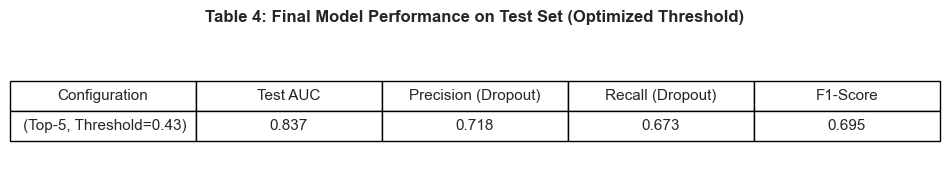

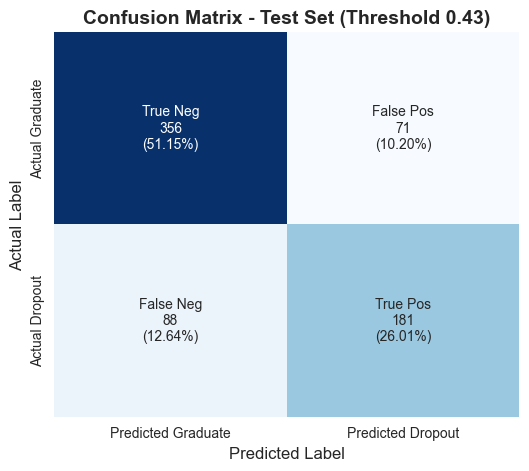

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- חלק 1: יצירת טבלה 4 (מדדים מספריים) ---

data_final = {
    "Configuration": [" (Top-5, Threshold=0.43)"],
    "Test AUC": [0.837],
    "Precision (Dropout)": [0.718],
    "Recall (Dropout)": [0.673],
    "F1-Score": [0.695]
}

df_final = pd.DataFrame(data_final)

# ציור הטבלה
fig, ax = plt.subplots(figsize=(10, 1.5)) # גובה נמוך כי יש רק שורה אחת
ax.axis('tight')
ax.axis('off')

table = ax.table(cellText=df_final.values,
                 colLabels=df_final.columns,
                 cellLoc='center',
                 loc='center')

table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.2, 1.8)

plt.title("Table 4: Final Model Performance on Test Set (Optimized Threshold)", y=1.2, fontweight='bold')
# plt.savefig("table4_final_metrics.png", bbox_inches='tight', dpi=300)
plt.show()


# --- חלק 2: יצירת Confusion Matrix ויזואלית (מומלץ מאוד להוסיף ליד הטבלה) ---

# נתוני המטריצה ששלחת
cm = np.array([[356, 71],
               [88, 181]])

# תוויות
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]

# שילוב הטקסטים לתצוגה בתוך הריבועים
labels = [f"{v1}\n{v2}\n({v3})" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', cbar=False,
            xticklabels=['Predicted Graduate', 'Predicted Dropout'],
            yticklabels=['Actual Graduate', 'Actual Dropout'])

plt.title('Confusion Matrix - Test Set (Threshold 0.43)', fontsize=14, fontweight='bold')
plt.ylabel('Actual Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)

# plt.savefig("final_confusion_matrix.png", bbox_inches='tight', dpi=300)
plt.show()

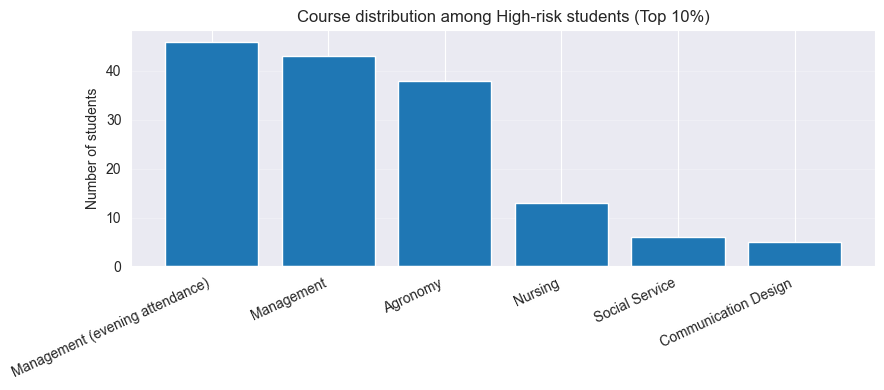

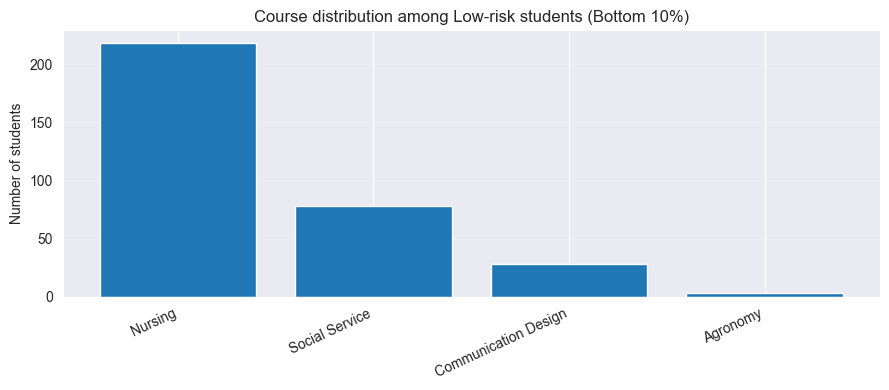

In [47]:
import matplotlib.pyplot as plt
import pandas as pd

course_map = {
    5:  "Communication Design",
    10: "Social Service",
    12: "Nursing",
    17: "Management (evening attendance)",
    9:  "Management",
    4:  "Agronomy",
}

courses_of_interest = list(course_map.keys())

def plot_course_counts(risk_label, title):
    sub = df_profile[
        (df_profile["risk_group"] == risk_label) &
        (df_profile["Course"].isin(courses_of_interest))
    ].copy()

    counts = sub["Course"].map(course_map).value_counts()

    plt.figure(figsize=(9,4))
    plt.bar(counts.index, counts.values)
    plt.xticks(rotation=25, ha="right")
    plt.ylabel("Number of students")
    plt.title(title)
    plt.grid(axis="y", alpha=0.25)
    plt.tight_layout()
    plt.show()

# 1) High risk
plot_course_counts(
    "High risk (top 10%)",
    "Course distribution among High-risk students (Top 10%)"
)

# 2) Low risk
plot_course_counts(
    "Low risk (bottom 10%)",
    "Course distribution among Low-risk students (Bottom 10%)"
)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) לוודא שהגיל נומרי
df_profile["Age at enrollment"] = pd.to_numeric(df_profile["Age at enrollment"], errors="coerce")

# 2) למשוך גילאים של שתי הקבוצות (כמו שהגדרת קודם)
age_high = df_profile.loc[df_profile["risk_group"] == "High risk (top 10%)", "Age at enrollment"].dropna()
age_low = df_profile.loc[df_profile["risk_group"] == "Low risk (bottom 10%)", "Age at enrollment"].dropna()

# 3) לצייר KDE (אם scipy מותקן)
try:
    from scipy.stats import gaussian_kde

    xs = np.linspace(
        min(age_low.min(), age_high.min()),
        max(age_low.max(), age_high.max()),
        300
    )

    kde_low = gaussian_kde(age_low)
    kde_high = gaussian_kde(age_high)

    plt.figure(figsize=(7, 4))
    plt.plot(xs, kde_low(xs), label="Low risk (bottom 10%)")
    plt.plot(xs, kde_high(xs), label="High risk (top 10%)")
    plt.xlabel("Age at enrollment")
    plt.ylabel("Density")
    plt.title("Age Distribution (Density) by Risk Group")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

except Exception as e:
    # fallback: אם scipy לא זמין, נציג היסטוגרמות מנורמלות במקום KDE
    plt.figure(figsize=(7, 4))
    plt.hist(age_low, bins=20, density=True, alpha=0.5, label="Low risk (bottom 10%)")
    plt.hist(age_high, bins=20, density=True, alpha=0.5, label="High risk (top 10%)")
    plt.xlabel("Age at enrollment")
    plt.ylabel("Density")
    plt.title("Age Distribution (Histogram Density) by Risk Group")
    plt.legend()
    plt.grid(True, alpha=0.3)

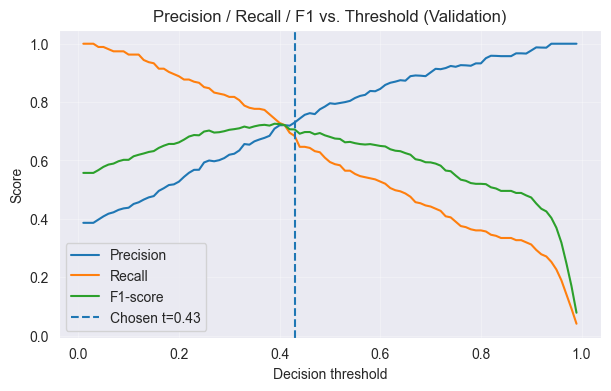

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

thresholds = np.linspace(0.01, 0.99, 99)

precisions, recalls, f1s = [], [], []

for t in thresholds:
    pred = (proba_val >= t).astype(int)
    precisions.append(precision_score(y_val, pred, zero_division=0))
    recalls.append(recall_score(y_val, pred))
    f1s.append(f1_score(y_val, pred, zero_division=0))

plt.figure(figsize=(7,4))
plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls, label="Recall")
plt.plot(thresholds, f1s, label="F1-score")

# אם בחרת threshold ספציפי (למשל 0.43)
chosen_t = 0.43
plt.axvline(chosen_t, linestyle="--", label=f"Chosen t={chosen_t}")

plt.xlabel("Decision threshold")
plt.ylabel("Score")
plt.title("Precision / Recall / F1 vs. Threshold (Validation)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


Logistic Regression results
Accuracy: 0.78
AUC: 0.837
Confusion Matrix:
 [[390  37]
 [116 153]]

Classification report:
               precision    recall  f1-score   support

           0       0.77      0.91      0.84       427
           1       0.81      0.57      0.67       269

    accuracy                           0.78       696
   macro avg       0.79      0.74      0.75       696
weighted avg       0.78      0.78      0.77       696



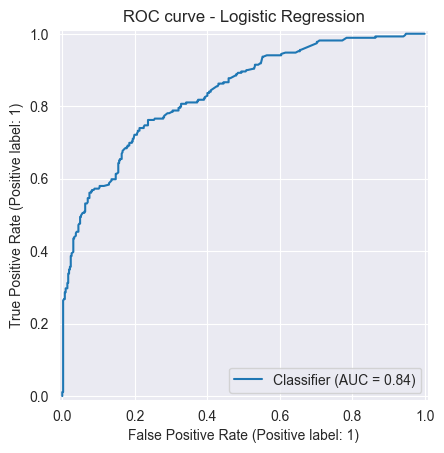


Random Forest results
Accuracy: 0.743
AUC: 0.82
Confusion Matrix:
 [[355  72]
 [107 162]]

Classification report:
               precision    recall  f1-score   support

           0       0.77      0.83      0.80       427
           1       0.69      0.60      0.64       269

    accuracy                           0.74       696
   macro avg       0.73      0.72      0.72       696
weighted avg       0.74      0.74      0.74       696



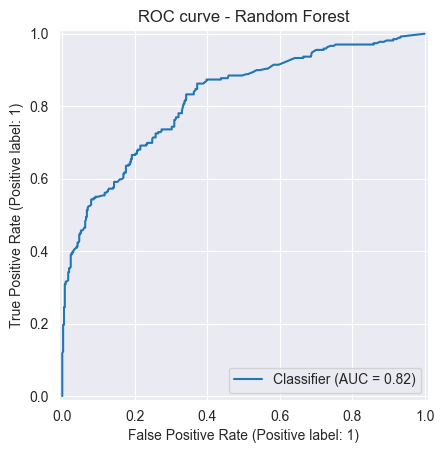


XGBoost results
Accuracy: 0.754
AUC: 0.83
Confusion Matrix:
 [[367  60]
 [111 158]]

Classification report:
               precision    recall  f1-score   support

           0       0.77      0.86      0.81       427
           1       0.72      0.59      0.65       269

    accuracy                           0.75       696
   macro avg       0.75      0.72      0.73       696
weighted avg       0.75      0.75      0.75       696



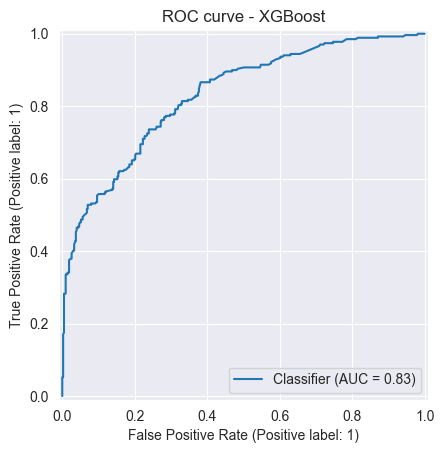

In [15]:
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

def evaluate(model, name):
    print("\n" + "="*70)
    print(f"{name} results")
    print("="*70)

    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    cm = confusion_matrix(y_test, y_pred)

    print("Accuracy:", round(acc, 3))
    print("AUC:", round(auc, 3))
    print("Confusion Matrix:\n", cm)
    print("\nClassification report:\n", classification_report(y_test, y_pred))

    # optional: ROC curve
    RocCurveDisplay.from_predictions(y_test, y_proba)
    plt.title(f"ROC curve - {name}")
    plt.show()

evaluate(pipe_log, "Logistic Regression")
evaluate(pipe_rf,  "Random Forest")
evaluate(pipe_xgb, "XGBoost")

### feature importance of the XGBoost model

In [16]:
xgb_model = pipe_xgb.named_steps["model"]

In [17]:
# Fit preprocessing on train data if not yet fitted
preprocess.fit(X_train)

ohe = preprocess.named_transformers_["cat"]
encoded_cat_names = list(ohe.get_feature_names_out(categorical_cols))

feature_names = numeric_cols + encoded_cat_names

NameError: name 'numeric_cols' is not defined

In [345]:
booster = xgb_model.get_booster()
importance_dict = booster.get_score(importance_type='gain')

In [346]:
importance_df = pd.DataFrame([
    (feature_names[int(k[1:])], v)
    for k, v in importance_dict.items()
], columns=["feature", "gain_importance"])

importance_df = importance_df.sort_values("gain_importance", ascending=False)
print(importance_df.head(20))

                 feature  gain_importance
29             Course_15        38.080742
30             Course_16        25.481026
31             Course_17         6.214075
18              Course_4         5.487823
27             Course_13         3.673408
19              Course_5         3.353660
23              Course_9         3.264867
7     Application mode_8         2.589591
3     Application mode_3         2.466770
20              Course_6         2.358370
21              Course_7         2.146057
22              Course_8         2.047601
12   Application mode_14         2.031007
0      Unemployment rate         1.988868
45  Age at enrollment_27         1.972272
40  Age at enrollment_22         1.817616
51  Age at enrollment_33         1.684169
1     Application mode_1         1.640298
60  Age at enrollment_42         1.606582
16              Course_2         1.556898


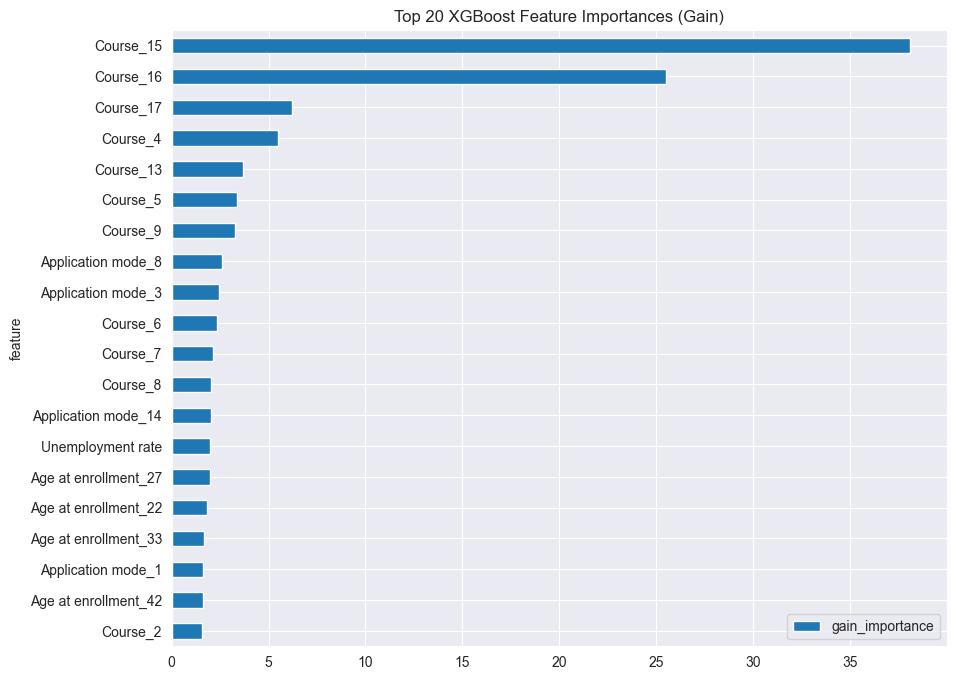

In [347]:
importance_df.head(20).plot(
    x='feature',
    y='gain_importance',
    kind='barh',
    figsize=(10,8)
)
plt.title("Top 20 XGBoost Feature Importances (Gain)")
plt.gca().invert_yaxis()
plt.show()

### Getting importance at the variable level (not each dummy)

In [348]:
# importance_df has columns: ["feature", "gain_importance"]

# base feature name = everything before the last underscore
importance_df["base_feature"] = importance_df["feature"].str.replace(r"_[^_]+$", "", regex=True)

# For numeric features (no underscore at the end) this leaves them as-is.

# Sum gain importance over all dummies of the same original feature
grouped_importance = (
    importance_df
    .groupby("base_feature")["gain_importance"]
    .sum()
    .sort_values(ascending=False)
)

print(grouped_importance.head(20))

base_feature
Course                     101.159061
Age at enrollment           37.873618
Application mode            19.566544
Scholarship holder           2.418778
Unemployment rate            1.988868
Tuition fees up to date      1.213735
Name: gain_importance, dtype: float64


In [27]:
import numpy as np
from sklearn.utils import resample
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score

# --- הגדרות ---
n_iterations = 1000  # כמה פעמים לדגום (סטנדרט מקובל)
confidence_level = 0.95 # רמת ביטחון (95%)
alpha = (1.0 - confidence_level) / 2.0 # (2.5% לכל צד)

# --- בחירת המודל לניתוח ---
# עדיף להשתמש במודל המכויל או ב-pipe_xgb/pipe_rf
current_model = pipe_xgb
# או: current_model = pipe_xgb

print(f"מבצע Bootstrapping (1000 חזרות) למודל: {current_model.steps[-1][1].__class__.__name__ if hasattr(current_model, 'steps') else 'CalibratedModel'}...")

# רשימות לשמירת התוצאות מכל הרצה
stats = {
    "AUC": [],
    "Precision (Dropout)": [],
    "Recall (Dropout)": [],
    "F1 Score": []
}

# --- חישוב תחזיות פעם אחת על כל הדאטה המקורי (לנוחות) ---
# הערה: בשיטה המחמירה ביותר היינו מריצים predict בתוך הלולאה,
# אבל כאן נדגום את התחזיות עצמן כדי לחסוך זמן חישוב, זה תקין סטטיסטית ל-Test Set.
all_y_true = y_test.values
all_y_pred = current_model.predict(X_test)
all_y_proba = current_model.predict_proba(X_test)[:, 1]

# --- לולאת ה-Bootstrap ---
for i in range(n_iterations):
    # 1. דגימה מחדש (Resampling)
    # אנו מגרילים אינדקסים ואז שולפים את הנתונים המתאימים
    indices = resample(range(len(all_y_true)), replace=True)

    y_true_boot = all_y_true[indices]
    y_pred_boot = all_y_pred[indices]
    y_proba_boot = all_y_proba[indices]

    # בדיקת קצה: לוודא שיש את שתי המחלקות (לפעמים בהגרלה יוצא רק 0 או רק 1)
    if len(np.unique(y_true_boot)) < 2:
        continue

    # 2. חישוב המדדים ושמירה
    stats["AUC"].append(roc_auc_score(y_true_boot, y_proba_boot))
    stats["Precision (Dropout)"].append(precision_score(y_true_boot, y_pred_boot, pos_label=1))
    stats["Recall (Dropout)"].append(recall_score(y_true_boot, y_pred_boot, pos_label=1))
    stats["F1 Score"].append(f1_score(y_true_boot, y_pred_boot, pos_label=1))

# --- הדפסת התוצאות ---
print(f"\n{'Metric':<20} | {'Mean':<8} | {'95% CI (Lower - Upper)':<25}")
print("-" * 60)

for metric_name, scores in stats.items():
    # המרת הרשימה למערך של numpy לחישובים
    scores = np.array(scores)

    # חישוב הממוצע והאחוזונים
    mean_score = np.mean(scores)
    lower = np.percentile(scores, alpha * 100)       # אחוזון 2.5
    upper = np.percentile(scores, (1.0 - alpha) * 100) # אחוזון 97.5

    print(f"{metric_name:<20} | {mean_score:.4f}   | [{lower:.4f} - {upper:.4f}]")

מבצע Bootstrapping (1000 חזרות) למודל: XGBClassifier...

Metric               | Mean     | 95% CI (Lower - Upper)   
------------------------------------------------------------
AUC                  | 0.8306   | [0.7999 - 0.8608]
Precision (Dropout)  | 0.7252   | [0.6636 - 0.7816]
Recall (Dropout)     | 0.5855   | [0.5284 - 0.6450]
F1 Score             | 0.6474   | [0.5969 - 0.6951]


# C-V

In [354]:
from sklearn.model_selection import cross_val_score

model_to_test = rf
#log_reg
#rf
#xgb
scores = cross_val_score(model_to_test, X, y, cv=5, scoring='accuracy')

print("\n--- תוצאות Cross Validation ---")
print(f"תוצאות לכל ריצה: {scores}")
print(f"דיוק ממוצע: {scores.mean():.4f}")
print(f"סטיית תקן (יציבות): {scores.std():.4f}")




--- תוצאות Cross Validation ---
תוצאות לכל ריצה: [0.74281609 0.78304598 0.74425287 0.77122302 0.78561151]
דיוק ממוצע: 0.7654
סטיית תקן (יציבות): 0.0185


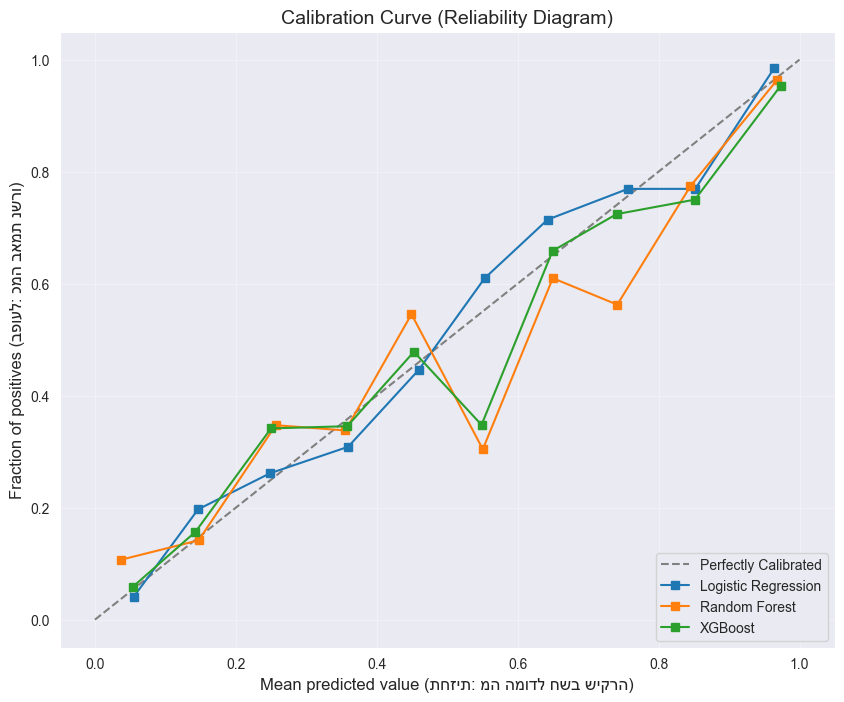

In [355]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

# --- 1. הגדרת המודלים להשוואה ---
# וודא שהשמות כאן תואמים לשמות המשתנים במחברת שלך
models_to_plot = {
    "Logistic Regression": pipe_log,   # בדרך כלל הכי מכויל
    "Random Forest": pipe_rf,          # נוטה להיות בצורת S
    "XGBoost": pipe_xgb                # לרוב חזק מאוד
}

plt.figure(figsize=(10, 8))

# --- 2. ציור קו הייחוס (המודל המושלם) ---
# קו אלכסוני אפור: המטרה שלנו היא להיות כמה שיותר קרובים אליו
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')

# --- 3. לולאה על כל המודלים וחישוב העקומה ---
for name, model in models_to_plot.items():
    # חישוב ההסתברויות (כמו שעשינו ב-AUC)
    if hasattr(model, "predict_proba"):
        prob_pos = model.predict_proba(X_test)[:, 1]
    else:
        # למקרה שיש מודל בלי predict_proba (נדיר בשימוש שלנו)
        continue

    # הפונקציה שמחשבת את הכיול
    # n_bins=10 אומר שאנחנו מחלקים את הסטודנטים ל-10 קבוצות לפי רמת הסיכון
    fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=10)

    # הוספה לגרף
    plt.plot(mean_predicted_value, fraction_of_positives, "s-", label=name)

# --- 4. עיצוב הגרף ---
plt.ylabel("Fraction of positives (בפועל: כמה באמת נשרו)", fontsize=12)
plt.xlabel("Mean predicted value (תחזית: מה המודל חשב שיקרה)", fontsize=12)
plt.title("Calibration Curve (Reliability Diagram)", fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)

plt.show()

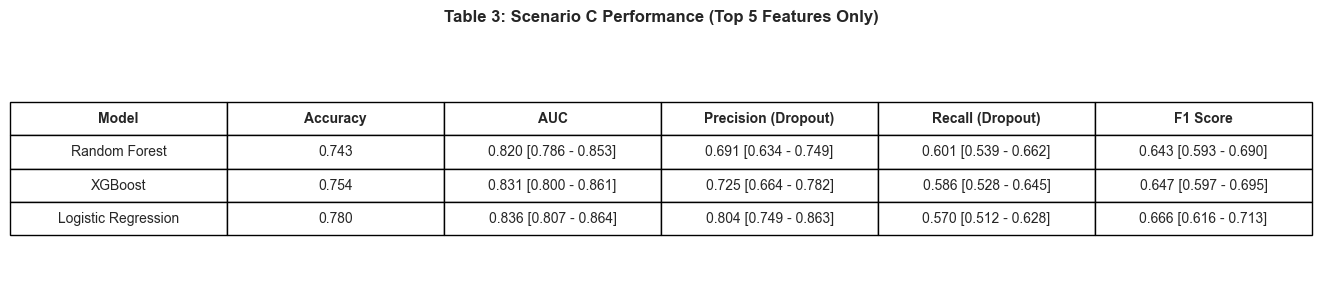

\begin{table}
\caption{Scenario C Performance metrics (Top 5 features) with 95% CI.}
\label{tab:scenario_c_ci}
\begin{tabular}{llllll}
\toprule
Model & Accuracy & AUC & Precision (Dropout) & Recall (Dropout) & F1 Score \\
\midrule
Random Forest & 0.743 & 0.820 [0.786 - 0.853] & 0.691 [0.634 - 0.749] & 0.601 [0.539 - 0.662] & 0.643 [0.593 - 0.690] \\
XGBoost & 0.754 & 0.831 [0.800 - 0.861] & 0.725 [0.664 - 0.782] & 0.586 [0.528 - 0.645] & 0.647 [0.597 - 0.695] \\
Logistic Regression & 0.780 & 0.836 [0.807 - 0.864] & 0.804 [0.749 - 0.863] & 0.570 [0.512 - 0.628] & 0.666 [0.616 - 0.713] \\
\bottomrule
\end{tabular}
\end{table}



In [28]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. הזנת הנתונים עבור Scenario C
# עיגלתי ל-3 ספרות עשרוניות לטובת אחידות וקריאות
data_c = {
    "Model": ["Random Forest", "XGBoost", "Logistic Regression"],

    "Accuracy": ["0.743", "0.754", "0.780"],

    "AUC": [
        "0.820 [0.786 - 0.853]",
        "0.831 [0.800 - 0.861]",
        "0.836 [0.807 - 0.864]"
    ],

    "Precision (Dropout)": [
        "0.691 [0.634 - 0.749]",
        "0.725 [0.664 - 0.782]",
        "0.804 [0.749 - 0.863]"
    ],

    "Recall (Dropout)": [
        "0.601 [0.539 - 0.662]",
        "0.586 [0.528 - 0.645]",
        "0.570 [0.512 - 0.628]"
    ],

    "F1 Score": [
        "0.643 [0.593 - 0.690]",
        "0.647 [0.597 - 0.695]",
        "0.666 [0.616 - 0.713]"
    ]
}

# 2. יצירת DataFrame
df_table3 = pd.DataFrame(data_c)

# 3. יצירת הטבלה הגרפית
fig, ax = plt.subplots(figsize=(14, 3))
ax.axis('tight')
ax.axis('off')

# יצירת אובייקט הטבלה
table = ax.table(cellText=df_table3.values,
                 colLabels=df_table3.columns,
                 cellLoc='center',
                 loc='center')

# 4. עיצוב
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 2)

# הדגשת שורת הכותרת
for (row, col), cell in table.get_celld().items():
    if row == 0:
        cell.set_text_props(weight='bold')

# 5. כותרת
plt.title("Table 3: Scenario C Performance (Top 5 Features Only)", y=1.1, fontweight='bold')

# שמירה
plt.savefig("table3_scenario_c_final.png", bbox_inches='tight', dpi=300)
plt.show()

# הדפסת LaTeX (אופציונלי)
print(df_table3.to_latex(index=False, caption="Scenario C Performance metrics (Top 5 features) with 95% CI.", label="tab:scenario_c_ci"))